In [2]:
# To make sure you have the packages required, run these lines
# !pip install Counter
# !pip install regex
# !pip install altair
# !pip install -r requirementsNLP.txt

In [53]:
import pandas as pd
import numpy as np

import json

import matplotlib.pyplot as plt
import altair as alt

import warnings
warnings.filterwarnings('ignore')

In [4]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\grace\\Desktop\\ta_119\\lab-nlp\\utils.py'>

# Bonus Lab: Natural Language Processing
Welcome to the NLP lab! Analyzing the data in text is extremely powerful and interesting, so I'm glad you're here.

We'll be analyzing the text of folktales from around the world, and how they reflect cultural values. Data was downloaded ([here](https://www.kaggle.com/datasets/andrzejpanczenko/folk-tales-dataset), accessed October 2022), and it contains 2,838 folktales from 57 nations. I've already processed added another column "language family" to serve as a proxy for cultural similarity between nations. <br>
The translation and codification drawbacks of this dataset for our analysis should be noted: can we really compare Gilgamesh to American folktale when one was mediated by outsiders and the other was written by the community that produced it? How do we differentiate a religious text from a folktale? However, it can still tell us something interesting about the cultures that produced them, and it will serve as a great introduction to NLP for you.

In [5]:
stories = pd.read_csv('data/stories.csv')
stories.head()

nation  language_family                      title  \
0               japanese        east_asia                   Momotaro   
1                serbian           slavic            The Birdcatcher   
2                 german         germanic     Sharing Joy and Sorrow   
3                 french           italic  The Punishment of Gangana   
4  north_american_native  native_american  The Peace with the Snakes   

                                                text  
0  If you’ll believe me there was a time when the...  
1  Near Constantinople there lived a man who knew...  
2  There was once a tailor, who was a quarrelsome...  
3  Once upon a time there lived a king and queen ...  
4  In those days there was a Piegan chief named O...

Here's an outline of what we'll be doing today:
1. [LIWC](#liwc) (Lexical Informativeness and Word Count)
2. [Data Cleaning](#cleaning) (tokenization, stopwords, lemmatization, bigrams)
3. [tf-idf](#tfidf) (term frequency-inverse document frequency)
4. [LDA Topic Modeling](#topics) (Latent Dirichlet Allocation)
5. [Doc2Vec](#embeddings) (word, document embeddings)

# 1. LIWC <a id="liwc"></a>
LIWC is a dictionary-based method for analyzing text. It uses a dictionary of words and their categories (such as "wealth", "leisure", "social", "positive emotion") to count the number of words in each category. You can find more information [here](https://www.liwc.net/LIWC2007LanguageManual.pdf).<br>

In [6]:
# Run this cell to load the dictionary
liwc_dict = utils.readDict('data/LIWC2007_English100131.dic')
liwc_dict[1]

odict_values([['funct'], ['pronoun'], ['ppron'], ['i'], ['we'], ['you'], ['shehe'], ['they'], ['ipron'], ['article'], ['verb'], ['auxverb'], ['past'], ['present'], ['future'], ['adverb'], ['preps'], ['conj'], ['negate'], ['quant'], ['number'], ['swear'], ['social'], ['family'], ['friend'], ['humans'], ['affect'], ['posemo'], ['negemo'], ['anx'], ['anger'], ['sad'], ['cogmech'], ['insight'], ['cause'], ['discrep'], ['tentat'], ['certain'], ['inhib'], ['incl'], ['excl'], ['percept'], ['see'], ['hear'], ['feel'], ['bio'], ['body'], ['health'], ['sexual'], ['ingest'], ['relativ'], ['motion'], ['space'], ['time'], ['work'], ['achieve'], ['leisure'], ['home'], ['money'], ['relig'], ['death'], ['assent'], ['nonfl'], ['filler']])

Here's an example of how to use the dictionary.

In [7]:
liwc_counts = utils.wordCount("I am having so much fun!", liwc_dict)
print(f'% posemo: {liwc_counts[0]["posemo"]/liwc_counts[2]:.2f}')
print(f'% negemo: {liwc_counts[0]["negemo"]/liwc_counts[2]:.2f}')
print(f'% pronoun: {liwc_counts[0]["pronoun"]/liwc_counts[2]:.2f}')

% posemo: 0.17
% negemo: 0.00
% pronoun: 0.17


Let's look at how the folktales from different language families compare in their use of social and family words.<br>
<br>
**Use the dictionary to count the proportion of social and family words in each story, and save the results in a new column `social` and `family`.** <br>
<br>
*Tip: notice that I saved the results of `wordCount` in a variable, so I didn't have to run it twice to access the "posemo" and total word counts. It would be a good idea to write a function that does the same, so you can apply it to the entire `text` column.*

In [8]:
stories['social'] = ...
stories['family'] = ...

In [9]:
# If you'd like to skip the wait, I've saved the data for you.
# Run this cell to load it.
stories['social'] = pd.read_pickle('data/social.pkl')
stories['family'] = pd.read_pickle('data/family.pkl')

<details><summary><button>Click here to reveal the answer!</button></summary>
def liwc_percent(word, liwc_dict, category):
    liwc_counts = utils.wordCount(word, liwc_dict)
    return liwc_counts[0][category]/liwc_counts[2]

stories['social'] = stories['text'].apply(lambda x: liwc_percent(x, liwc_dict, 'social'))
stories['family'] = stories['text'].apply(lambda x: liwc_percent(x, liwc_dict, 'family'))
</pre>
</details>

To look at how cultural values vary with cultural stories, let's use Hofstede's six cultural dimensions. The data was downloaded [here](https://www.kaggle.com/code/tarukofusuki/hofstede-s-cultural-dimensions-notebook/data), and you can learn more about it's development [here](https://scholarworks.gvsu.edu/orpc/vol2/iss1/8/). We're interested in the `idv` column, which stands for individualism.<br><br>
Using LIWC, this we're able to find that there's a slight negative correlation between indidividualism and social/family words. Nations that are more individualistic tend to have less social and family words in their folktales. 

In [10]:
hofstede = pd.read_csv('data/hofstede.csv')
hofstede.head()

main     pdi     idv     mas    uai     ltowvs        ivr  estim
0     albanian  90.000  20.000  80.000  70.00  61.460957  14.508929   1.00
1       arabic  79.375  33.625  53.125  70.75  20.053212  29.138393   0.75
2     armenian  85.000  22.000  50.000  88.00  60.957179  25.000000   1.00
3  azerbaijani  85.000  22.000  50.000  88.00  61.000000  22.000000   1.00
4       bahasa  89.000  20.000  48.000  42.00  51.385390  47.433036   0.00

Text(0.5, 1.0, 'Individualism vs. Social/Family Features')

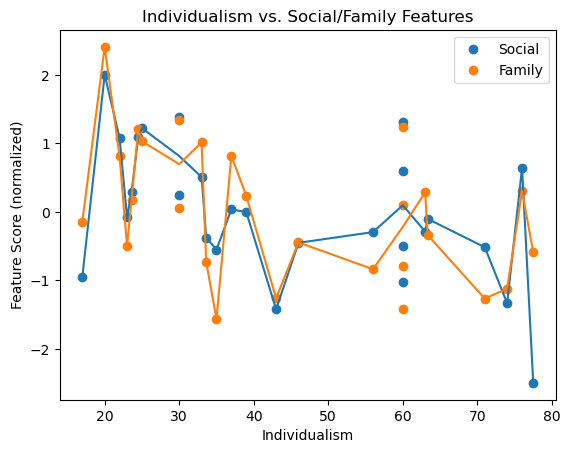

In [11]:
stories_hofstede = stories.groupby('nation').mean().reset_index()[['nation','social','family']]
stories_hofstede = pd.merge(stories_hofstede, hofstede, left_on='nation', right_on='main')

stories_hofstede['social'] = (stories_hofstede['social'] - stories_hofstede['social'].mean())/stories_hofstede['social'].std()
stories_hofstede['family'] = (stories_hofstede['family'] - stories_hofstede['family'].mean())/stories_hofstede['family'].std()

plt.plot(stories_hofstede['idv'], stories_hofstede['social'], 'o', color='tab:blue')
plt.plot(stories_hofstede['idv'], stories_hofstede['family'], 'o', color='tab:orange')

by_idv = stories_hofstede.groupby('idv').mean().reset_index()
plt.plot(by_idv['idv'], by_idv['social'], color='tab:blue')
plt.plot(by_idv['idv'], by_idv['family'], color='tab:orange')

plt.ylabel('Feature Score (normalized)')
plt.xlabel('Individualism')
plt.legend(['Social', 'Family'])
plt.title('Individualism vs. Social/Family Features')

Great! Although this data is messy, we've found a pattern and an indication of a relationship. <br>
<br>
By counting the number of times a word category appears and dividing by the total word count, we're using something similar to tf-idf (term frequency-inverse document frequency). tf-idf is a way of weighting words based on how often they appear in a document, and how often they appear in the entire corpus. It's a great way to find the most important words in a document, but we'll first need to clean up the text a bit.

# 2. Data Cleaning <a id="cleaning"></a>
To make this data ready for more complex analysis, such as tf-idf and topic modeling, we'll need to clean the text up quite a bit.

## 2.1 Tokenization
Tokenization is the process of breaking up a string of text into smaller pieces (sentences, words, characters), called tokens. We'll be using the `nltk` package to do this.

Before we tokenize the text, we'll need to remove punctuation. We'll also need to convert all the text to lowercase, so that "The" and "the" are treated as the same word.

**Write a function to remove punctuation from a string of text. Use the function and an existing string function to clean `momotaro`.**<br>
*Hint: `string.punctuation` contains all the punctuation characters.*

In [12]:
import string
momotaro = stories[stories['title'] == 'Momotaro']['text'].values[0]

In [14]:
def remove_punc(text):
    ...

In [16]:
momotaro_clean = ...

<details><summary><button>Click here to reveal the answer!</button></summary>
def remove_punc(text):
    for punc in string.punctuation:
        text = text.replace(punc, '')
    return text

momotaro_clean = remove_punc(momotaro).lower()
</pre>
</details>

In [13]:
# *!
def remove_punc(text):
    for punc in string.punctuation:
        text = text.replace(punc, '')
    return text

momotaro_clean = remove_punc(momotaro).lower()

We'll use the `nltk` package to tokenize the text. The `nltk` package has a function called `word_tokenize` that will do this for us.

In [18]:
import nltk

momotaro_words = nltk.word_tokenize(momotaro_clean)
momotaro_words[:5]

['if', 'you', '’', 'll', 'believe']

## 2.2 Stopwords

To remove stopwords, we'll use the `nltk` package again. Stopwords are words that are so common that they don't add much meaning to a sentence. For example, "the", "a", and "and" are stopwords.<br>

**Use the `STOP` package to remove stopwords from `momotaro`.**<br>

In [16]:
STOP = set(nltk.corpus.stopwords.words('english'))

momotaro_words = ...

<details><summary><button>Click here to reveal the answer!</button></summary>
momotaro_words = [w for w in momotaro_words if w not in STOP]
</details>

In [19]:
STOP = set(nltk.corpus.stopwords.words('english'))
momotaro_words = [w for w in momotaro_words if w not in STOP]
# *!

In [20]:
momotaro_words[:5]

['’', 'believe', 'time', 'fairies', 'none']

Although `nltk`'s stopwords are quite comprehensive, there are still many words that are very common specific to this dataset that are not interesting.

In [21]:
from collections import Counter
momotaro_common_words = Counter(momotaro_words).most_common(10)
momotaro_common_words = {w[0] for w in momotaro_common_words}
momotaro_common_words

{'man', 'momotaro', 'ogres', 'old', 'peach', 'says', 'woman', '’', '“', '”'}

Using Momotaro as an example, we can see the ten most common words (which includes strange quotes!). If we wanted to analyze the the uniqueness of parts within the story, these are what we would remove. However, we want to remove the most common words in the entire dataset. <br>
<br>

**Create a column `words` that contains a list of the words in each story. Use this column to create a list `common_words` of the 50 most common words in the entire dataset using `Counter`.**<br>
*Hint: `Counter` takes a single list (of words) as input.*

In [ ]:
stories['words'] = ...
common_words = ...

<details><summary><button>Click here to reveal the answer!</button></summary>
stories['words'] = stories['text'].apply(lambda x: nltk.word_tokenize(remove_punc(x).lower()))

allwords = []
for i in range(len(stories)):
    words = stories['words'].iloc[i]
    allwords += words
common_words = Counter(allwords).most_common(50)
common_words = {w[0] for w in common_words}
</details>

In [22]:
# *!
stories['words'] = stories['text'].apply(lambda x: nltk.word_tokenize(remove_punc(x).lower()))

allwords = []
for i in range(len(stories)):
    words = stories['words'].iloc[i]
    allwords += words
common_words = Counter(allwords).most_common(50)
common_words = {w[0] for w in common_words}

## 2.3 Lemmatization

Lemmatization is the process of reducing words to their root form. For example, "running" and "ran" would both be reduced to "run". This is useful because it reduces the number of unique words in our dataset, and it makes it easier to compare words that are similar but not identical.<br>
<br>
We'll use the `common_words` in the function `get_lemmas`.<br>

In [23]:
# Run this cell. 
# I've included the code here (rather than in utils.py) so you can see what's going on.
def get_wordnet_pos(word):
    '''
    Tags each word with its Part-of-speech indicator -- specifically used for
    lemmatization in the get_lemmas function
    '''
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': nltk.corpus.wordnet.ADJ,
                'N': nltk.corpus.wordnet.NOUN,
                'V': nltk.corpus.wordnet.VERB,
                'R': nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def get_lemmas(text):
    lemmas = [nltk.stem.WordNetLemmatizer().lemmatize(t, get_wordnet_pos(t))
              for t in nltk.word_tokenize(text.lower()) if t not in STOP and t not in common_words]
    return [l for l in lemmas if len(l) > 3]

In [24]:
momotaro_lemmas = get_lemmas(momotaro)
momotaro_lemmas[:5]

['believe', 'time', 'fairy', 'none', 'time']

It takes awhile to lemmatize all the stories. I've done it for you and saved the results. Run the next cell to load it.

In [25]:
# stories['lemmas'] = stories['text'].apply(lambda x: get_lemmas(x))
# stories['lemmas'].to_pickle('lemmas.pkl')
stories['lemmas'] = pd.read_pickle('data/lemmas.pkl')

Note: stemming is another way to reduce words to their root form. For your purposes, you don't need to worry about stemming, but here's [more information](https://www.turing.com/kb/stemming-vs-lemmatization-in-python) if you're interested.

## 2.4 Bigrams
Before we start playing with this data, let's make bigrams. N-grams are groups of n words that appear together in a document. We'll use a function to find bigrams that occur at least ten times, and freeze them together.<br>
<br>
**Use the function `make_bigrams` to make bigrams for all the stories. Save the results in a new column `final_wordlist`.**

In [26]:
from gensim import models

def make_bigrams(lemmas,min_count=10):
    bigram = models.Phrases(lemmas, min_count=min_count)
    bigram_mod = bigram.freeze()
    return [bigram_mod[doc] for doc in lemmas]

In [ ]:
stories['final_wordlist'] = ...

<details><summary><button>Click here to reveal the answer!</button></summary>
stories['final_wordlist'] = make_bigrams(stories['lemmas'])
</pre>
</details>

In [27]:
# *!
stories['final_wordlist'] = make_bigrams(stories['lemmas'])

# 3. tf-idf <a id="tfidf"></a>
Let's look at if there are any tropes that are common in folktales from different language families. We'll use tf-idf to find the most important words in each story, and then we'll look at the most important words in each language family.

`sklearn` is your friend here. It has a function called `TfidfVectorizer` that will do most the work for us. Here's a modified example from the documentation.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
     'This is the first document.',
     'This document is the second document.',
     'And this is the third one.',
     'Molly ran to the store.'
     'Bob was running to the store.'
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())

and       bob  document     first        is     molly       one  \
0  0.000000  0.000000  0.479038  0.607599  0.387823  0.000000  0.000000   
1  0.000000  0.000000  0.737324  0.000000  0.298463  0.000000  0.000000   
2  0.494641  0.000000  0.000000  0.000000  0.315723  0.000000  0.494641   
3  0.000000  0.266413  0.000000  0.000000  0.000000  0.266413  0.000000   

        ran   running    second     store       the     third      this  \
0  0.000000  0.000000  0.000000  0.000000  0.317070  0.000000  0.387823   
1  0.000000  0.000000  0.467601  0.000000  0.244013  0.000000  0.298463   
2  0.000000  0.000000  0.000000  0.000000  0.258124  0.494641  0.315723   
3  0.266413  0.266413  0.000000  0.532826  0.278051  0.000000  0.000000   

         to       was  
0  0.000000  0.000000  
1  0.000000  0.000000  
2  0.000000  0.000000  
3  0.532826  0.266413

Notice that the vectorizer takes in a list of strings. As in the example, if we pass raw (un-lemmatized, with stopwords), the matrix it returns includes all variations of lemmas and all present stopwords. For our analysis, we want to use the lemmatized, stopwords-removed wordlists we made earlier. We'll need to convert the wordlists into strings. <br>
<br>

In [29]:
stories['text_cleaned'] = stories['final_wordlist'].apply(lambda x: ' '.join(x))

Because we are comparing nation to nation, and not story to story, we'll need to combine all the stories from each nation into one string. We'll do this by joining the strings in the `text_cleaned` column with a space between each string. <br>

In [30]:
nations, texts = [], []
for nat in stories['nation'].unique():
    nations.append(nat)
    texts.append(' '.join(stories[stories['nation'] == nat]['text_cleaned'].values))

**Use `TfidfVectorizer` to create a tf-idf matrix for the `texts` list. Save the result in dataframe `tfidf`, with columns names as the tokens.**<br>

<details><summary><button>Click here to reveal the answer!</button></summary>
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)
tfidf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())
</details>

In [31]:
# *!
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)
tfidf = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())

In [32]:
# Run this cell to make the dataframe easier to work with
tfidf = tfidf.T.reset_index()
tfidf.columns = ['word'] + nations
tfidf.head()

word  japanese  serbian    german  french  north_american_native  \
0   000       0.0      0.0  0.000000     0.0               0.000000   
1    10       0.0      0.0  0.000548     0.0               0.000000   
2  1000       0.0      0.0  0.000000     0.0               0.000000   
3  1001       0.0      0.0  0.000000     0.0               0.000000   
4  1007       0.0      0.0  0.000000     0.0               0.000666   

   brazilian  armenian  english  russian  ...  belgian  spanish  cataloanian  \
0        0.0       0.0      0.0      0.0  ...      0.0      0.0          0.0   
1        0.0       0.0      0.0      0.0  ...      0.0      0.0          0.0   
2        0.0       0.0      0.0      0.0  ...      0.0      0.0          0.0   
3        0.0       0.0      0.0      0.0  ...      0.0      0.0          0.0   
4        0.0       0.0      0.0      0.0  ...      0.0      0.0          0.0   

   bulgarian  bukovinian  new_zealand_native  sami  pakistani  lithuanian  \
0        0.0         0.0                 0.0   0.0        0.0         0.0   
1        0.0         0.0                 0.0   0.0        0.0         0.0   
2        0.0         0.0                 0.0   0.0        0.0         0.0   
3        0.0         0.0                 0.0   0.0        0.0         0.0   
4        0.0         0.0                 0.0   0.0        0.0         0.0   

   zimbabwe  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  

[5 rows x 58 columns]

**Write a function `compare_ab` that takes two nations and returns a dataframe comparing the tf-idf scores for each tokens.**<br>
<br>
Consider:
- How can you find the tokens with the most similar scores?
    - Remember, most values in the matrix are 0, so you'll need to find a way to ignore those.
- How can you find the tokens with the most different scores?

In [158]:
def compare_ab():
    ...

<details><summary><button>Click here to reveal the answer!</button></summary>
def compare_ab_helper(a,b, similar_score = True):
    ab = tfidf[['word',a,b]].copy()
    ab['diff'] = np.abs(ab[a] - ab[b])
    if similar_score:
        ab = ab.query(f'{a} > 0 and {b} > 0')
    return ab.sort_values('diff', ascending=similar_score).head(10)

def compare_ab(a,b):
    sim, diff = compare_ab_helper(a,b)['word'].values, compare_ab_helper(a,b, similar_score=False)['word'].values
    print(f'Words that are similar in {a} and {b}: {sim}')
    print(f'\nWords that are different in {a} and {b}: {diff}')
</details>

In [33]:
# *!
def compare_ab_helper(a,b, similar_score = True):
    ab = tfidf[['word',a,b]].copy()
    ab['diff'] = np.abs(ab[a] - ab[b])
    if similar_score:
        ab = ab.query(f'{a} > 0 and {b} > 0')
    return ab.sort_values('diff', ascending=similar_score).head(10)

def compare_ab(a,b):
    sim, diff = compare_ab_helper(a,b)['word'].values, compare_ab_helper(a,b, similar_score=False)['word'].values
    print(f'Words that are similar in {a} and {b}: {sim}')
    print(f'\nWords that are different in {a} and {b}: {diff}')

In [34]:
compare_ab('greek','japanese')

Words that are similar in greek and japanese: ['threaten' 'know_whether' 'posse' 'perceive' 'comfortably' 'jumping'
 'gaily' 'cradle' 'bake' 'something_else']

Words that are different in greek and japanese: ['theseus' 'momotaro' 'jason' 'monkey' 'perseus' 'rice' 'urashima'
 'jupiter' 'athens' 'badger']


# 4. Topic Modeling <a id="topics"></a>
tf-idf can also be used to find what a story is about. However, there are packages that are specifically designed to do this. We'll use LDA (Latent Dirichlet Allocation) to find the topics in each story. <br>

In [39]:
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [41]:
# The LDA model takes a corpus and a dictionary as input. 
# We'll also use these to visualize the topics later.
dictionary = corpora.Dictionary(stories['final_wordlist'])
corpus = [dictionary.doc2bow(text) for text in stories['final_wordlist']]

In [42]:
# The model takes a while to run, so I've saved it for you.
# Run this cell to load the model.

# lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, passes=20)
# lda.save('data/lda/ldamodel.model')
lda = models.ldamodel.LdaModel.load('data/lda/ldamodel.model')

In [43]:
# This helps us visualize the topics. 
pyLDAvis.enable_notebook()
gensimvis.prepare(lda, corpus, dictionary)

c:\Users\grace\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.155884 -0.004546       1        1  29.166856
2     -0.127867 -0.051865       2        1  27.053470
5     -0.144208  0.044187       3        1  19.000522
4     -0.101064  0.056636       4        1  13.335717
3     -0.074782 -0.070726       5        1   8.182538
6      0.073648  0.135389       6        1   1.709175
0      0.188145 -0.174179       7        1   0.996233
1      0.342012  0.065104       8        1   0.555488, topic_info=         Term          Freq         Total Category  logprob  loglift
39       come  23076.000000  23076.000000  Default  30.0000  30.0000
561      well   8285.000000   8285.000000  Default  29.0000  29.0000
972      like   8052.000000   8052.000000  Default  28.0000  28.0000
391      look   8600.000000   8600.000000  Default  27.0000  27.0000
955      king  13767.000000  13767.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
811      drew     30.031799    846.531558   Topic8  -5.8517   1.8542
3117    goose     17.263816    204.463570   Topic8  -6.4054   2.7213
2597  picture     17.549301    402.459728   Topic8  -6.3890   2.0605
8867     worm     16.554764    150.357855   Topic8  -6.4473   2.9867
972      like     16.914074   8052.341773   Topic8  -6.4258  -0.9725

[616 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
11011      7  0.989604       a-gun
19790      4  0.975791      aegeus
11029      7  0.981236        agen
16570      3  0.981857       ahmed
11031      7  0.981207       ahter
...      ...       ...         ...
11212      7  0.998361        yust
69198      1  0.989872   zoolvisia
14188      6  0.976405        æsir
14189      6  0.974586  æsir_vanir
22948      1  0.990364      ––then

[1521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 6, 5, 4, 7, 1, 2])

Notice that in the creation of the model, we had to specify how many topics we wanted. In your own analysis, you'll need to decide how many topics you want to find using the above visualization. Ideally, the circles would not overlap, indicating that each topic is unique. If one circle is entirely inside another, then you have too many topics.

In [44]:
# This cell helps us interpret the topics.
topics_df = pd.DataFrame()
topics = lda.print_topics(num_words=10)
for topic in topics:
    topicwords = topic[1].split(' + ')
    topicwords = [x.split('*')[1].replace('"','') for x in topicwords]
    topics_df[f'Topic {topic[0]}'] = topicwords
topics_df

Topic 0  Topic 1 Topic 2 Topic 3   Topic 4   Topic 5 Topic 6   Topic 7
0      wolf    pedro  little    come      come    prince    thor      king
1      yust    taffy    come    make      upon     would   giant      come
2  jackalse     stan   would    take     great  princess    come      take
3      well    daddy    make    back      like      king   would      give
4      dere  tegumai   could   would      look      make    loki     would
5      like    mikko    look    away  mountain      take    odin    prince
6      come     draw    like   woman      land     could    make  daughter
7      look    shark    well    look     could      give  sigurd      well
8      time   walter    take    time     water     great  asgard  princess
9      back    saint    time    give      long      time   petru     could

Sometimes it's hard to interpret what the topic represents. Here, Topic 6 seems to be clearly about Norse mythology.<br>
<br>
LDA topic modeling gives you a percent breakdown of each topic in each story. Let's look at the distribution of topics across nations.

In [45]:
# Run this cell to fill topic weights.
stories_topic = stories[['title','nation','language_family']].copy()
stories_topic = stories_topic.apply(utils.fill_topic_weights, axis=1, args=[corpus,lda]).fillna(0)
stories_topic.head()

0         1         2         3    4         5    6         7  \
0  0.0  0.000000  0.452028  0.000000  0.0  0.000000  0.0  0.545663   
1  0.0  0.000000  0.000000  0.224949  0.0  0.447948  0.0  0.326336   
2  0.0  0.000000  0.288855  0.000000  0.0  0.130051  0.0  0.576114   
3  0.0  0.049218  0.343301  0.000000  0.0  0.549679  0.0  0.057512   
4  0.0  0.000000  0.058247  0.920846  0.0  0.000000  0.0  0.020357   

   language_family                 nation                      title  
0        east_asia               japanese                   Momotaro  
1           slavic                serbian            The Birdcatcher  
2         germanic                 german     Sharing Joy and Sorrow  
3           italic                 french  The Punishment of Gangana  
4  native_american  north_american_native  The Peace with the Snakes

<Figure size 1500x1500 with 0 Axes>

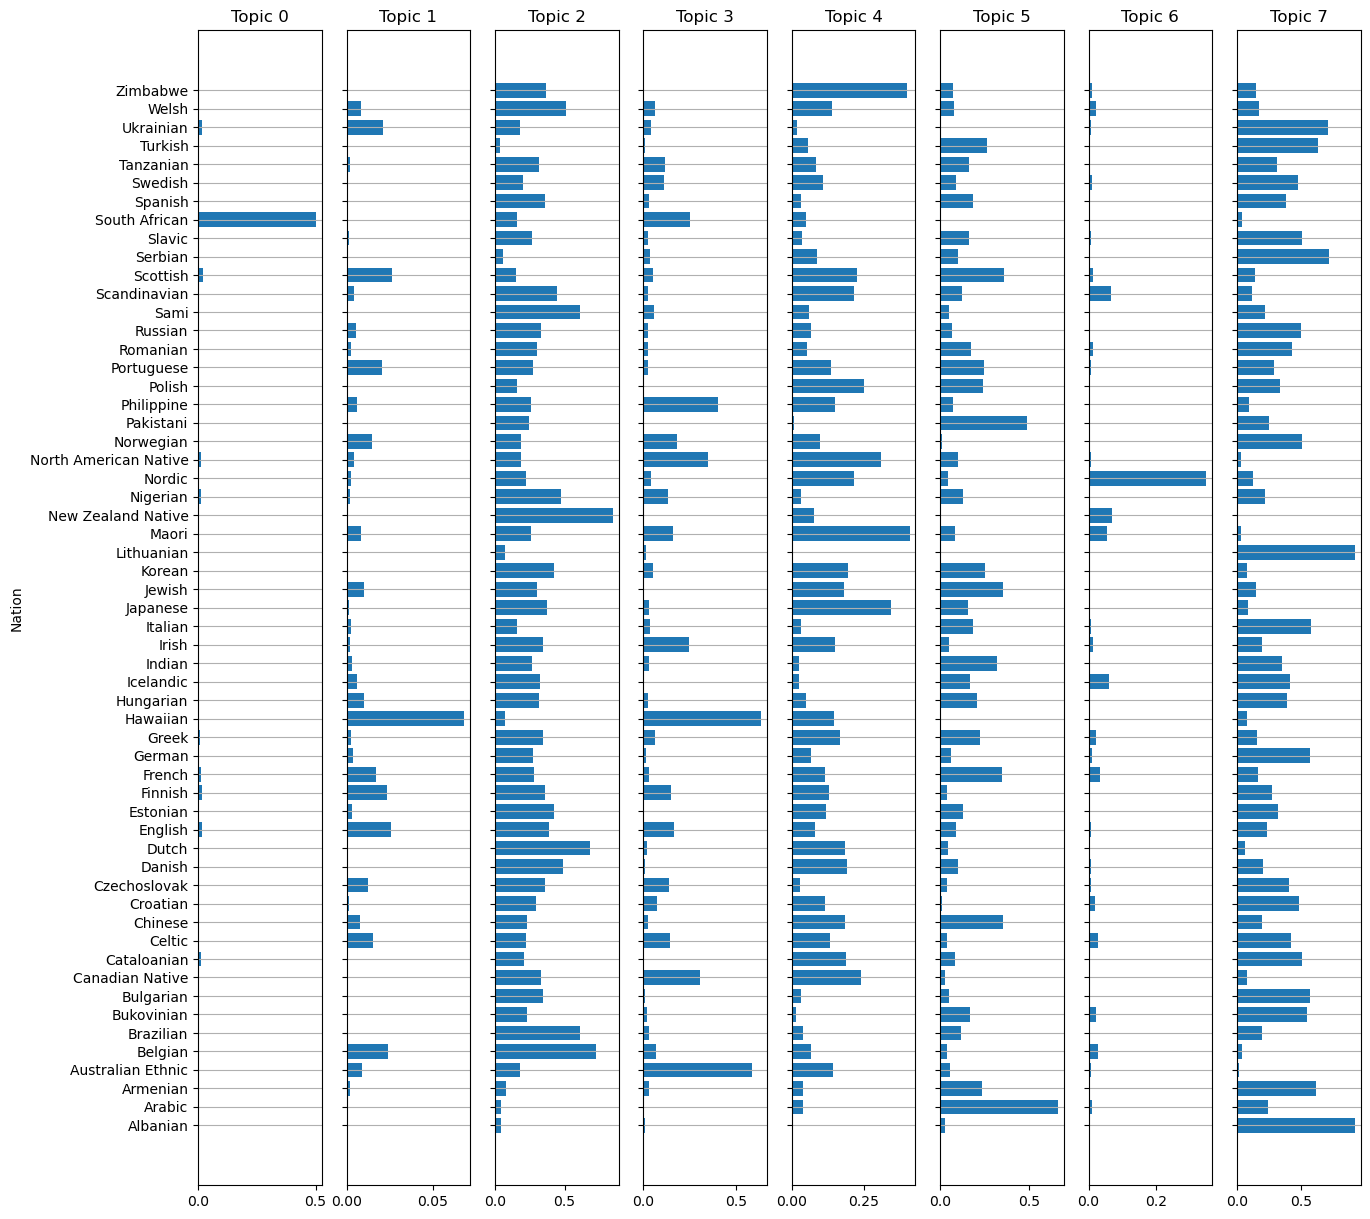

In [46]:
nation_topic = stories_topic.groupby('nation').mean().T
nation_topic.columns = nation_topic.columns.str.title().str.replace('_',' ')
plt.figure(figsize=(15,15))
fig, axes = plt.subplots(1,8, figsize=(15,15))
for i, topic in enumerate(nation_topic.index):
    axes[i].barh(nation_topic.columns, nation_topic.loc[topic])
    axes[i].grid(axis= 'y')
    if i == 0:
        axes[i].set_ylabel('Nation')
        axes[i].set_yticks(nation_topic.columns)
    else:
        axes[i].set_yticklabels([])
    axes[i].set_title(f'Topic {topic}')
plt.show()

This is quite a large bar chart! But it shows a lot of information at once -- we can see that Topic 0 almost entirely belongs to South Africa, Topic 1 mostly to Hawaii, and Topic 6 to Norway. <br>
<br>
(Note: if I was more focused on the visualization than the NLP method here, I would have shown each topic as a separate bar chart. Don't turn in visualizations that are hard to read!)

# 5. Word2Vec and Doc2Vec <a id="embeddings"></a>
How do we start to compare how similar stories are to each other? We can use word embeddings to find the most similar words to a given word, and we can use document embeddings to find the most similar stories to a given story.<br> 

## 5.1 Word2Vec
The basic idea of word embeddings is that the meaning of a word can be understood by the words that are around it. For example, 'Shanghai' might be used in a similar sentence as 'DC'. Using some really cool machine learning, these words can be embedded as vectors, with many dimensions. You can imagine dimensions as representing aspects of a word. This means we can do math with words -- e.g. $Shanghai - China + US = DC$. There are a few other embedding models (GLOVE, FastText), but here we'll use Word2Vec. <br>  

In [47]:
w2v_model = models.Word2Vec(stories['final_wordlist'], vector_size=300, window=5, min_count=5, workers=4)

Below, I have some functions you can do with Word2Vec. Try it out!

In [48]:
# This shows you what words most often appear in the same context as 'thor'.
# Try it with other words, like 'queen'.
w2v_model.wv.most_similar('thor')

[('hammer', 0.8598306775093079),
 ('loki', 0.85953688621521),
 ('thor_hammer', 0.7933017611503601),
 ('hymer', 0.7846062779426575),
 ('miölnir', 0.7778710722923279),
 ('club', 0.7668140530586243),
 ('hammer.', 0.7664204239845276),
 ('fenrir', 0.7496549487113953),
 ('monster', 0.7408095002174377),
 ('strike', 0.7396100759506226)]

In [49]:
# This picks out the odd one out in a list of words.
w2v_model.wv.doesnt_match(['thor','odin','queen'])

'queen'

In [50]:
# This shows an analogy. King is to queen as husband is to ...?
w2v_model.wv.most_similar(positive=['king','husband'], negative=['queen'])

[('stepmother', 0.624147891998291),
 ('step-mother', 0.6200984120368958),
 ('wife', 0.6165943145751953),
 ('intend', 0.5990285873413086),
 ('son-in-law', 0.5905701518058777),
 ('brahman', 0.5884491205215454),
 ('wife.', 0.5836955308914185),
 ('widow', 0.5802732110023499),
 ('wife.but', 0.5666625499725342),
 ('home.', 0.5639020800590515)]

## 5.2 Doc2Vec
Take this idea, and apply it to documents. We can embed each story as a vector, and then we can find the most similar stories to a given story. This is called document embeddings. <br>

In [51]:
d2v_corpus = [models.doc2vec.TaggedDocument(words=l, tags=[str(i)]) for i, l in enumerate(stories['final_wordlist'])]
d2v_model = models.doc2vec.Doc2Vec(d2v_corpus, vector_size=300, window=5, min_count=5, workers=8)

In [54]:
# This takes a few seconds to run. Don't run it if you don't need to.
tsne_df = utils.doc2vec_tsne(d2v_model)
tsne_df = tsne_df.merge(stories[['title','nation','language_family']], left_index=True, right_index=True, suffixes=('',''))
big_families = ['germanic','slavic','italic','austronesian']
tsne_bigfamilies = pd.DataFrame()
for fam in big_families:
    tsne_bigfamilies = pd.concat([tsne_bigfamilies,tsne_df.query(f'language_family == "{fam}"')])

tsne_bigfamilies['nation'] = tsne_bigfamilies['nation'].apply(lambda x: x.replace(' ','_').title())
tsne_bigfamilies['language_family'] = tsne_bigfamilies['language_family'].apply(lambda x: x.replace(' ','_').title())

alt.Chart(tsne_bigfamilies).mark_point(filled=True, opacity=0.5).encode(
    alt.X('X1',scale=alt.Scale(zero=False)),
    alt.Y('X2',scale=alt.Scale(zero=False)),
    color=alt.Color('nation',legend=None),
    facet=alt.Facet('language_family:N',columns=2,header=alt.Header(labelFontSize=20)),
    tooltip = [alt.Tooltip('nation')]
).properties(width=300,height=300)

alt.Chart(...)

Great! Using Doc2Vec, we can see clusters of stories that are similar to each other often belong to the same nation.

# 6. Sentiment Analysis <a id="sentiment"></a>
Sentiment analysis looks at the words in a sentence and assigns a score for positive, negative, and neutral polarities, based on empirically created scores. For example, a word like "happy" would be calculated as having a positive score, while a word like "angry" would be defined as having a negative score. The final compound score is a normalization of the three polarity scores - thus, a negative compound score means the string was overall negative in sentiment, positive meaning the string was overall positive, and 0 being classified as "neutral". 


In [59]:
utils.sentiment_analyzer_sin("I've had so much fun learning about natural language processing!")

0.7484

In [65]:
stories['text_cleaned'][:1]

0    believe time fairy none time beast talk spell_...
Name: text_cleaned, dtype: object

In [67]:
!pip install transformers

  Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
  Using cached tokenizers-0.13.2-cp39-cp39-win_amd64.whl (3.3 MB)
  Using cached huggingface_hub-0.12.0-py3-none-any.whl (190 kB)


In [ ]:
import transformers
transforme

In [66]:
from transformers import pipeline

ModuleNotFoundError: No module named 'transformers'

In [64]:
utils.sentiment_analyzer_list(["I'm having fun."])

(['believe time fairy none time beast talk spell_enchantment magic every great_store hidden_treasure adventure asking.at time must know woman live_alone good poor child all.one fine morning good woman. mountain billhook gather faggot stick fire good wife woman stream wash_clothes wash adds.so mountain woman stream.now wash_clothes fine ripe peach come float_stream peach enough rosy sides. luck morning dame pull peach shore split bamboo stick.by-and-by good come home hill peach good lucky peach found stream brought home you. never taste peach sudden peach burst stone fine baby stone been. mercy woman. mercy man.the baby first half peach half finer strong ever. momotaro momotaro eldest peach. truth indeed woman born peach. take good care momotaro soon stoutest bravest country-side credit believe neighbour head momotaro fine young mother momotaro woman make good store kimi-dango call millet dumpling part want kimi-dango mother. momotaro journey adventure shall need kimi-dango way. momotar

In [ ]:
def sentiment_analyzer_list(doclist):
    
    analyser  = SentimentIntensityAnalyzer()
    pos, neg, neut  = [], [], []
    
    for doc in doclist:
        score = analyser.polarity_scores(doc)
        
        if score['compound']   >0: # positive comments
            pos.append(doc)
        elif score['compound'] <0: # negative comments
            neg.append(doc)
        else:
            neut.append(doc)
    return (pos, neut, neg)

def sentiment_analyzer_sin(doc):
    
    analyser  = SentimentIntensityAnalyzer()
    
    score = analyser.polarity_scores(doc)
    return score['compound']